# Table of Contents
 <p><div class="lev1"><a href="#Derive-scaling"><span class="toc-item-num">1&nbsp;&nbsp;</span>Derive scaling</a></div><div class="lev2"><a href="#Compute-statistics"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compute statistics</a></div><div class="lev3"><a href="#1D-PDFs"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>1D PDFs</a></div><div class="lev3"><a href="#PDF-of-scaling-in-percentile-bins-of-pr"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>PDF of scaling in percentile bins of pr</a></div><div class="lev3"><a href="#2D-PDFs"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>2D PDFs</a></div><div class="lev3"><a href="#Decompose-bias-into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Decompose bias into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev2"><a href="#Decompose-the-variance"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Decompose the variance</a></div><div class="lev3"><a href="#Decompose-Variance-into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Decompose Variance into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev3"><a href="#Decompose-variance-into-its-contributions-from-T-and-omega-(ignore-variability-in-pressure)"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Decompose variance into its contributions from T and omega (ignore variability in pressure)</a></div><div class="lev2"><a href="#Predictor-variables-statistics"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Predictor variables statistics</a></div><div class="lev3"><a href="#Joint-statistics-of-$\omega$-and-$q_v^\star$"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Joint statistics of $\omega$ and $q_v^\star$</a></div><div class="lev3"><a href="#Conditional-values-of-$P$-on-joint-statistics-of-$\omega$-and-$q_v^\star$"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Conditional values of $P$ on joint statistics of $\omega$ and $q_v^\star$</a></div><div class="lev1"><a href="#Save-all-variables-in-dataframe"><span class="toc-item-num">2&nbsp;&nbsp;</span>Save all variables in dataframe</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

print("-- loading modules")
print()

import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import datetime as dt
import time
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
from plotMaps import *
from plot1DInvLog import *
from plot2D import *
from statisticalDistributions import *
from outputResults import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

-- loading modules

Own modules available: ['plot1DInvLog', 'thermoFunctions', 'statisticalDistributions', 'slicingAndSubsetting', 'plot2D', 'outputResults', 'thermoConstants', 'plotMaps', 'daskOptions', 'scalingApproximations', 'CAMsettings', 'environmentAndDirectories', 'importingData', 'physicalConstants']


In [3]:
%%time
print("-- load environment and variables")
print()

omega_id = 'OMEGA'
pr_id = 'PRECT'
ts_id = 'TS'
ta_id = 'T'
relhum_id = 'RELHUM'
ps_id = 'PS'

all_varnames = 'omega','pr','ts','ta','relhum','ps','pres'

ref_time_stride = '1h'
ref_resolution = '1dx'

print("- load data for the following options:")
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
daskarray = False
tracktime = True
dates = ('185005010100','185005020000')
handle = 'h0'

-- load environment and variables

- load data for the following options:
CPU times: user 274 µs, sys: 69 µs, total: 343 µs
Wall time: 172 µs


In [4]:
if tracktime:
    t0 = time.time()
    t_loops = []

In [8]:
for v in ['compset','experiment','member','subset','ref_time_stride','ref_resolution',\
          'daskarray','dates']:
    print("%s:"%v,getattr(thismodule,v))

print()
omega_init,pr_init,ts_init,ta_init,relhum_init,ps_init = \
    getValues([omega_id,pr_id,ts_id,ta_id,relhum_id,ps_id],
              compset,subset,experiment,ref_time_stride,ref_resolution,
              daskarray=daskarray,dates=dates,handle=handle)
pr_init *= rho_l    # convert from m/s to kg/m2/s

print()
print("get inputpaths")

historyFilesSettings = getCAMHistoryFilesSettings()
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

print("compute pressure levels")
    
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)
pres_init = computeP(ps_init)

cn = getArrayType(pres_init)

compset: FSPCAMm_AMIP
experiment: piControl
member: r1i1p1
subset: tropics
ref_time_stride: 1h
ref_resolution: 1dx
daskarray: False
dates: ('185005010100', '185005020000')

Importing OMEGA, PRECT, TS, T, RELHUM, PS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000

get inputpaths
compute pressure levels


In [11]:
if tracktime:
    t1 = time.time()
    t_loops.append(t1)
    print("! time spent to load the data:",t1-t0)
    print()

! time spent to load the data: 145.69092512130737



In [12]:
# single scale
time_stride = '12h'
resolution = '1dx'

# # multiple scales
# time_strides = '1h','3h','6h','12h','1d','2d','4d','8d'
# resolutions = '1dx','2dx','3dx','4dx','5dx','6dx','7dx','8dx','9dx'
# for time_stride in time_stride:
#     for resolution in resolutions:

#+++# start indentation for multiple scales

print()
print("----------------------------------------------------------------")
print("!          Start analysis for time_stride %s"%time_stride)
print("!                          and resolution %s"%resolution)
print("----------------------------------------------------------------")
print()


----------------------------------------------------------------
!          Start analysis for time_stride 12h
!                          and resolution 1dx
----------------------------------------------------------------



In [13]:
print("convert data to target resolutions")

for varname in all_varnames:
    
    setattr(thismodule,varname,
            coarsenTimeStride(coarsenResolution(getattr(thismodule,"%s_init"%varname),
                                                resolution),
                              time_stride))


convert data to target resolutions


In [14]:
print()
print("-- define output paths")
print()

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(figdir,exist_ok=True)

# Results output directory
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(resultdir,exist_ok=True)

print()


-- define output paths




# Derive scaling

In [15]:
print()
print("-- compute (percentile-wise and pointwise) scaling approximation")
print()


-- compute (percentile-wise and pointwise) scaling approximation



In [16]:
%%time
print("compute 2D surfaces of predictor variables")
p_500 = 50000
p_925 = 92500; levdim=1
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
use925 = True
if use925:
    ta_925 = isobaricSurface(ta,pres,p_ref=p_925,levdim=levdim) 
    qvstar_s = saturationSpecificHumidity(ta_925,p_925*np.ones(ps.shape))
else:
    qvstar_s = saturationSpecificHumidity(ts,ps)

compute 2D surfaces of predictor variables
CPU times: user 194 ms, sys: 8.42 ms, total: 202 ms
Wall time: 201 ms


In [94]:
%%time
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,n_pts_per_bin=1,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)
iQ_min = 8
iQ_max = min(len(Q_IL),41)
# iQ_max = min(len(Q_IL),iQ_slice.stop)

# Define reference percentiles and compute percentiles
targetranks = Q_IL[iQ_min:iQ_max]
ranks_ref = Q_IL[:iQ_max]
percentiles = adjustRanks(centers,ranks,ranks_ref)

# Suffix to save figures and results
output_suffix = 'Q%d-Q%d_%s'%(iQ_min,iQ_max,'-'.join(dates))

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()

Compute ranks and ranks locations
0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 
CPU times: user 28.2 ms, sys: 1.69 ms, total: 29.9 ms
Wall time: 25.3 ms


In [95]:
print("compute sample size in each bin")
N_prQ = sampleSizeAtAllRanks(targetranks,pr,ranks_ref,rank_locations=rank_locations)
print(np.nansum(N_prQ),pr.size)

compute sample size in each bin
65338.0 294912


> Plot sample size in each percentile bin


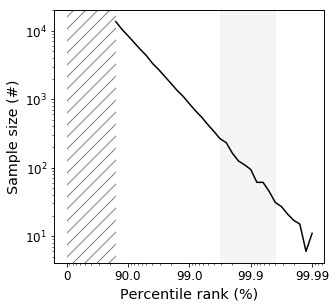

In [96]:
print("> Plot sample size in each percentile bin")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')

# Add zero line
addZeroLine(ax,ranks_ref)

# Grey shading
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

subplotRanksILog(ax,ranks_ref,
                 N_prQ,
                 col='k',ltype='-',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Sample size (#)')

plt.savefig(os.path.join(figdir,'sample_size_in_P_bins_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

In [97]:
%%time
print("compute pointwise scaling")
eps, pr_sc_vQ = computeScalingOmegaQAtAllRanks(targetranks,omega_500,qvstar_s,pr,ranks_ref=ranks_ref[iQ_slice],
                                               percentiles_ref=percentiles[iQ_slice],
                                               bins=bins,rank_locations=rank_locations)
pr_sc_vQ = adjustRanks(pr_sc_vQ,targetranks,ranks_ref)
pr_sc = singleLevelScalingFromOmegaQ(omega_500,qvstar_s,efficiency=eps)
print("eps =",eps)

compute pointwise scaling
eps = 0.820531342032
CPU times: user 52.4 ms, sys: 38 µs, total: 52.4 ms
Wall time: 51 ms


In [98]:
%%time
print("compute O'Gorman&Schneider scaling with environmental temperature profile")
eps_OGS09, pr_scOGS09_vQ = computeScalingOGS09AtAllRanks(targetranks,omega,ta,pres,pr,
    ranks_ref=ranks_ref[iQ_slice],percentiles_ref=percentiles[iQ_slice],bins=bins,
                                                         rank_locations=rank_locations)
pr_scOGS09_vQ = adjustRanks(pr_scOGS09_vQ,targetranks,ranks_ref)
pr_scOGS09 = scalingOGS09(omega,ta,pres,efficiency=eps_OGS09,levdim=1)
print("eps_OGS09 =",eps_OGS09)

compute O'Gorman&Schneider scaling with environmental temperature profile
eps_OGS09 = 1.01330192935
CPU times: user 17.2 s, sys: 3.26 s, total: 20.5 s
Wall time: 20.5 s


In [99]:
%%time
print("compute O'Gorman&Schneider scaling with moist adiabat")
# Get temperature values at lowest level
levdim = 1
nlev = pres.shape[levdim]
i_bottom = bottomIndex(np.moveaxis(pres,levdim,-1).ravel()[-nlev:])
ta_bottom = np.take(ta,axis=levdim,indices=i_bottom)
# Compute scaling
eps_OGS09ad, pr_scOGS09ad_vQ = computeScalingOGS09AtAllRanks(targetranks,omega,ta_bottom,pres,pr,
    temp_type='adiabat',relhum=relhum,ranks_ref=ranks_ref[iQ_slice],percentiles_ref=percentiles[iQ_slice],bins=bins,
                                                         rank_locations=rank_locations)
pr_scOGS09ad_vQ = adjustRanks(pr_scOGS09ad_vQ,targetranks,ranks_ref)
pr_scOGS09ad = scalingOGS09(omega,ta_bottom,pres,temp_type='adiabat',relhum=relhum,efficiency=eps_OGS09ad,levdim=1)
print("eps_OGS09ad =",eps_OGS09ad)

compute O'Gorman&Schneider scaling with moist adiabat
eps_OGS09ad = 1.04247822669
CPU times: user 19.2 s, sys: 3.26 s, total: 22.5 s
Wall time: 22.5 s


In [100]:
%%time
print("compute extended O'Gorman&Schneider scaling with environmental temperature profile")
fracarea_boost, entrainment, pr_scRH_vQ = computeScalingRHAtAllRanks(targetranks,omega,ta,pres,relhum,pr,
    ranks_ref=ranks_ref[iQ_slice],bins=bins,rank_locations=rank_locations)
pr_scRH_vQ = adjustRanks(pr_scRH_vQ,targetranks,ranks_ref)
pr_scRH = scalingRH(omega,ta,pres,relhum,fracarea_boost=fracarea_boost,entrainment=entrainment,levdim=1)
print(pr_scRH.shape)
print("fracarea_boost =",fracarea_boost)
print("entrainment =",entrainment)

compute extended O'Gorman&Schneider scaling with environmental temperature profile


KeyboardInterrupt: 

In [101]:
%%time
print("compute extended O'Gorman&Schneider scaling with moist adiabat")
# Get temperature values at lowest level
levdim = 1
nlev = pres.shape[levdim]
i_bottom = bottomIndex(np.moveaxis(pres,levdim,-1).ravel()[-nlev:])
ta_bottom = np.take(ta,axis=levdim,indices=i_bottom)
# Compute scaling
fracarea_boost_ad, entrainment_ad, pr_scRHad_vQ = computeScalingRHAtAllRanks(targetranks,omega,ta_bottom,pres,relhum,pr,
    temp_type='adiabat',ranks_ref=ranks_ref[iQ_slice],bins=bins,rank_locations=rank_locations)
pr_scRHad_vQ = adjustRanks(pr_scRHad_vQ,targetranks,ranks_ref)
pr_scRHad = scalingRH(omega,ta_bottom,pres,relhum,fracarea_boost=fracarea_boost_ad,entrainment=entrainment_ad,
                    temp_type='adiabat',levdim=1)
print(pr_scRHad.shape)
print("fracarea_boost =",fracarea_boost_ad)
print("entrainment =",entrainment_ad)

compute extended O'Gorman&Schneider scaling with moist adiabat


KeyboardInterrupt: 

## Compute statistics

### 1D PDFs

In [102]:
print()
print("-- compute statistics")
print()


-- compute statistics



In [103]:
# %%time
print("mean of scalings in pr bins")
pr_sc_prQ = meanXAtAllYRanks(targetranks,pr_sc,pr,ranks_ref,rank_locations=rank_locations)
pr_scOGS09_prQ = meanXAtAllYRanks(targetranks,pr_scOGS09,pr,ranks_ref,rank_locations=rank_locations)
pr_scOGS09ad_prQ = meanXAtAllYRanks(targetranks,pr_scOGS09ad,pr,ranks_ref,rank_locations=rank_locations)
pr_scRH_prQ = meanXAtAllYRanks(targetranks,pr_scRH,pr,ranks_ref,rank_locations=rank_locations)
pr_scRHad_prQ = meanXAtAllYRanks(targetranks,pr_scRHad,pr,ranks_ref,rank_locations=rank_locations)

mean of scalings in pr bins


IndexError: boolean index did not match indexed array along dimension 0; dimension is 32 but corresponding boolean dimension is 64

In [104]:
%%time
print("interquartile and 90% ranges")
ranks_I90 = (5,95)
ranks_IQR = (25,75)

pr_sc_I90 = XPercentilesAtAllYRanks(targetranks,pr_sc,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_sc_IQR = XPercentilesAtAllYRanks(targetranks,pr_sc,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scOGS09_I90 = XPercentilesAtAllYRanks(targetranks,pr_scOGS09,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scOGS09_IQR = XPercentilesAtAllYRanks(targetranks,pr_scOGS09,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scOGS09ad_I90 = XPercentilesAtAllYRanks(targetranks,pr_scOGS09ad,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scOGS09ad_IQR = XPercentilesAtAllYRanks(targetranks,pr_scOGS09ad,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scRH_I90 = XPercentilesAtAllYRanks(targetranks,pr_scRH,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scRH_IQR = XPercentilesAtAllYRanks(targetranks,pr_scRH,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scRHad_I90 = XPercentilesAtAllYRanks(targetranks,pr_scRHad,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scRHad_IQR = XPercentilesAtAllYRanks(targetranks,pr_scRHad,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)


interquartile and 90% ranges


IndexError: boolean index did not match indexed array along dimension 0; dimension is 32 but corresponding boolean dimension is 64

> plot PDF with scaling and variability
- scaling sc


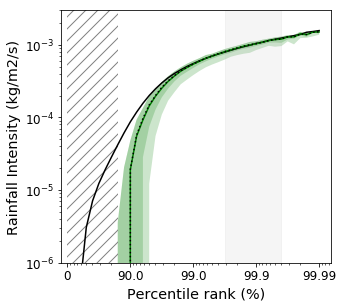

- scaling scOGS09


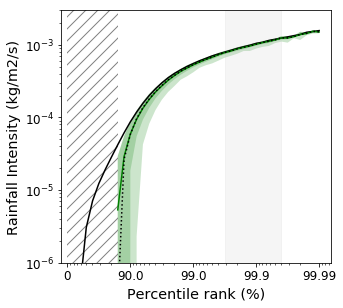

- scaling scOGS09ad


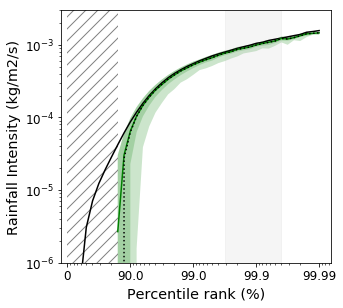

- scaling scRH


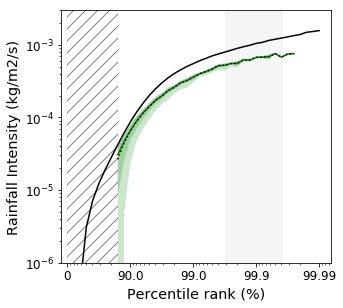

- scaling scRHad


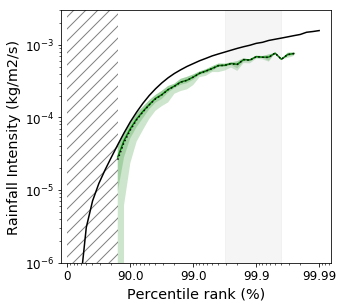

In [105]:
print("> plot PDF with scaling and variability")

scaling_names = 'sc','scOGS09','scOGS09ad','scRH','scRHad'

for sc_name in scaling_names:

    print("- scaling %s"%sc_name)

    for suffix in 'prQ','vQ','IQR','I90':
        setattr(thismodule,'var_%s'%suffix,getattr(thismodule,'pr_%s_%s'%(sc_name,suffix)))
    
    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

    ax.set_yscale('log')
    ax.set_ylim((1e-6,3e-3))

    # Grey shading 
    i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
    subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)
    # 90% confidence interval for pointwise scaling 2
    subplotYShadingRanksILog(ax,ranks_ref,[var_I90[:,0],var_IQR[:,1]],col='green',transformX=False)
    # Interquartile range for pointwise scaling 2
    subplotYShadingRanksILog(ax,ranks_ref,[var_IQR[:,0],var_IQR[:,1]],col='green',transformX=False)
    # Mean of pointwise scaling 2
    subplotRanksILog(ax,ranks_ref,[percentiles,var_prQ,var_vQ],col=['k','green','k'],ltype=['-','-',':'],\
                     transformX=False)

    addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

    ax.set_xlabel('Percentile rank (%)')
    ax.set_ylabel('Rainfall Intensity (kg/m2/s)')
    # ax.set_title(r'$\varepsilon\omega_{500}q_v^\star(T)$')

    plt.savefig(os.path.join(figdir,'pdf_P_and_P%s_mean_IQR_I90_%s.pdf'%(sc_name,output_suffix)),
                bbox_inches='tight')

    plt.show()

### PDF of scaling in percentile bins of pr

In [106]:
print()
print("-- compute PDF of scalings in percentile bins of pr")
print()


-- compute PDF of scalings in percentile bins of pr



In [107]:
print("reference Q_slices")
iQ_slices = [slice(i_Q-k,i_Q+k) for k in range(1,6)]

reference Q_slices


In [111]:
varname_ref = 'pr'
var_ref = getattr(thismodule,varname_ref)

varnames = 'pr_sc','pr_scOGS09','pr_scOGS09ad','pr_scRH','pr_scRHad'

for varname in varnames:
    
    print("- %s"%varname)

    var = getattr(thismodule,varname)

    for k in range(len(iQ_slices)):
        
        iQ_min = min(iQ_slices[k].start,ranks_ref.size-1)
        iQ_max = min(iQ_slices[k].stop,ranks_ref.size-1)

        print("Q-slice %2.4f-%2.4f"%(ranks_ref[iQ_min],ranks_ref[iQ_max]))

        sample_all = []
        for i in range(iQ_min,iQ_max):
            stencil_Q = getStencilAtRank(ranks_ref[i],ranks_ref,bins,var_ref)
            if stencil_Q.sum() != 0:
                sample_all.append(var[stencil_Q])
        if len(sample_all) == 0:
            sample = np.array([])
        else:
            sample = np.hstack(sample_all)
        # perc,b = defineLinearBins(sample,20)
        ra,perc,b,den = compute1dDensities(sample[np.logical_not(np.isnan(sample))],n_lin_bins=20)
        # Save
        ra_varname = 'ranks_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_min,iQ_max)
        perc_varname = 'percentiles_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_min,iQ_max)
        b_varname = 'bins_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_min,iQ_max)
        den_varname = 'pdf1D_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_min,iQ_max)
        setattr(thismodule,ra_varname,ra)
        setattr(thismodule,perc_varname,perc)
        setattr(thismodule,b_varname,b)
        setattr(thismodule,den_varname,den)


- pr_sc
Q-slice 99.8741-99.9206
Q-slice 99.8415-99.9369
Q-slice 99.8005-99.9499
Q-slice 99.7488-99.9602
Q-slice 99.6838-99.9684
- pr_scOGS09
Q-slice 99.8741-99.9206
Q-slice 99.8415-99.9369
Q-slice 99.8005-99.9499
Q-slice 99.7488-99.9602
Q-slice 99.6838-99.9684
- pr_scOGS09ad
Q-slice 99.8741-99.9206
Q-slice 99.8415-99.9369
Q-slice 99.8005-99.9499
Q-slice 99.7488-99.9602
Q-slice 99.6838-99.9684
- pr_scRH
Q-slice 99.8741-99.9206


IndexError: boolean index did not match indexed array along dimension 0; dimension is 32 but corresponding boolean dimension is 64

> Plot pdf of last computed conditioned on high percentiles of pr


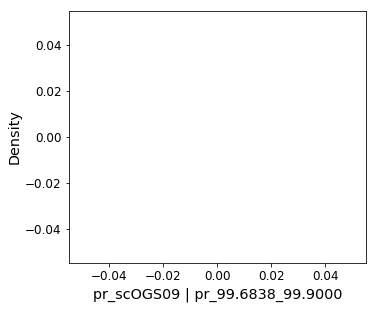

In [29]:
print("> Plot pdf of last computed conditioned on high percentiles of pr")

varname = 'pr_scOGS09'

perc = getattr(thismodule,'percentiles_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_min,iQ_max))

fig,ax = plt.subplots(figsize=(5.5,4.5))
plt.plot(perc,den)
ax.set_xlabel("%s | %s_%2.4f_%2.4f"%(varname,varname_ref,ranks_ref[iQ_min],ranks_ref[iQ_max]))
ax.set_ylabel('Density')

plt.savefig(os.path.join(figdir,'conditional_pdf_%s_%s_%2.4f_%2.4f_%s.pdf'%(varname,varname_ref,
                                                                            ranks_ref[iQ_min],
                                                                            ranks_ref[iQ_max],
                                                                            output_suffix)),
                bbox_inches='tight')

plt.show()

### 2D PDFs

In [471]:
print()
print("-- compute 2D PDF of scalings and pr")
print()


-- compute 2D PDF of scalings and pr



In [478]:
# %%time
print("compute 2D PDFs")

all_pr_varnames = set({'pr','pr_sc','pr_scOGS09','pr_scOGS09ad','pr_scRH','pr_scRHad'})

for varname1 in all_pr_varnames:
    for varname2 in all_pr_varnames.difference(varname1):

        var1 = getattr(thismodule,varname1)
        var2 = getattr(thismodule,varname2)
        
        ranks1, percentiles1, bins1, ranks2, percentiles2, bins2, density2D = \
            compute2dStatsILOnRefRanks(var1,var2,ranks_ref)
            
        setattr(thismodule,"density2D_%s_%s"%(varname1,varname2),density2D)

        N1 = sampleSizeAtAllRanks(ranks1,var1,ranks_ref,bins=bins1)
        N2 = sampleSizeAtAllRanks(ranks2,var2,ranks_ref,bins=bins2)
        norm_factor = normalize2dDensity(N1,N2,n_pts)

        norm_density2D = density2D/norm_factor
        setattr(thismodule,"norm_density2D_%s_%s"%(varname1,varname2),norm_density2D)
        setattr(thismodule,"N_%s"%(varname1),N1)
        setattr(thismodule,"N_%s"%(varname2),N2)

compute 2D PDFs


> plot 2D PDFs
- pr_scRHad vs. pr_scRHad


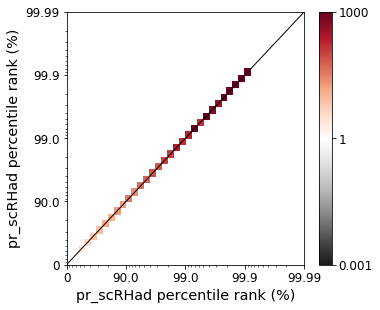

- pr_scRH vs. pr_scRHad


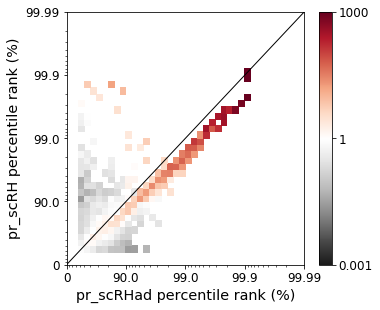

- pr_sc vs. pr_scRHad


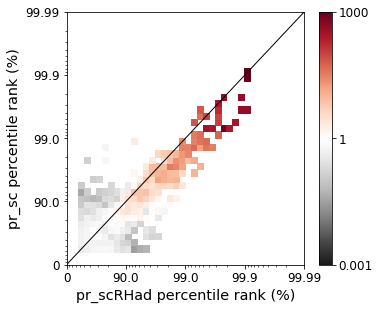

- pr vs. pr_scRHad


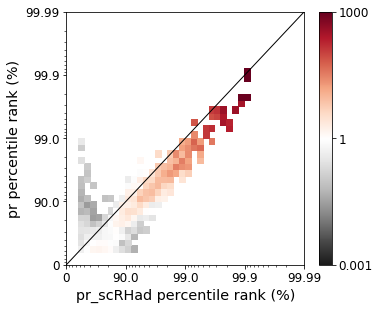

- pr_scOGS09ad vs. pr_scRHad


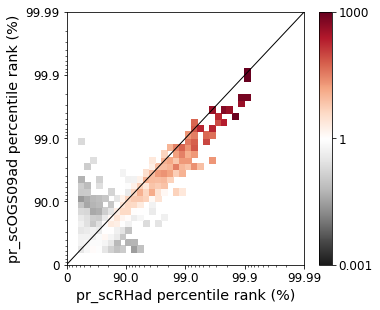

- pr_scOGS09 vs. pr_scRHad


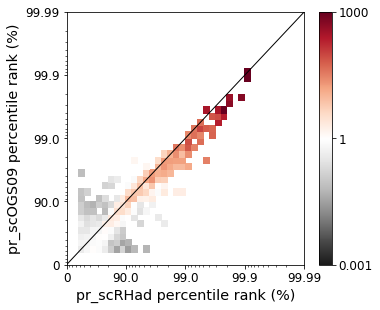

In [488]:
print("> plot 2D PDFs")

plotAll2dPDFs = True

if plotAll2dPDFs:
    
    for varname1 in all_pr_varnames:
        for varname2 in all_pr_varnames:
            
            print("- %s vs. %s"%(varname2,varname1))

            norm_density2D = getattr(thismodule,"norm_density2D_%s_%s"%(varname1,varname2))

            fig, ax = plt.subplots(figsize=(5.5,4.5))

            # cmap = plt.cm.RdBu_r
            cmap = plt.cm.RdGy_r
            # cmap = plt.cm.RdYlBu_r
            # cmap = plt.cm.PRGn
            
            subplot2DRanksILog(ax,ranks_ref,ranks_ref,norm_density2D,cmap=cmap,
                transformX=True,transformY=True,Z_mode='log')

            add1to1Line(ax)

            ax.set_xlabel('%s percentile rank (%%)'%varname1)
            ax.set_ylabel('%s percentile rank (%%)'%varname2)

            plt.savefig(os.path.join(figdir,'norm_pdf2D_%s_and_%s_%s.pdf'%(varname1,varname2,output_suffix)),
                            bbox_inches='tight')
            plt.show()

### Decompose bias into its contributions from qvstar and omega (scaling #3)

In [489]:
print()
print("-- decompose bias into qvstar and omega contributions")
print()


-- decompose bias into qvstar and omega contributions



In [490]:
%%time
print("Q-mean terms")
qvstar_s_prQ = meanXAtAllYRanks(targetranks,qvstar_s,pr,ranks_ref,rank_locations=rank_locations)
omega_500_prQ = meanXAtAllYRanks(targetranks,omega_500,pr,ranks_ref,rank_locations=rank_locations)

Q-mean terms
CPU times: user 5.99 ms, sys: 990 µs, total: 6.98 ms
Wall time: 6.07 ms


In [491]:
%%time
print("Compute bias")
bias_sc = (pr_sc_prQ - pr_sc_vQ)/pr_sc_prQ
bias_scOGS09 = (pr_scOGS09_prQ - pr_scOGS09_vQ)/pr_scOGS09_prQ
bias_scOGS09ad = (pr_scOGS09ad_prQ - pr_scOGS09ad_vQ)/pr_scOGS09ad_prQ
bias_scRH = (pr_scRH_prQ - pr_scRH_vQ)/pr_scRH_prQ
bias_scRHad = (pr_scRHad_prQ - pr_scRHad_vQ)/pr_scRHad_prQ
print("single-level scaling:",np.nanmean(bias_sc[iQ_slice]))
print("OGS09 scaling:",np.nanmean(bias_scOGS09[iQ_slice]))
print("OGS09ad scaling:",np.nanmean(bias_scOGS09ad[iQ_slice]))
print("RH scaling:",np.nanmean(bias_scRH[iQ_slice]))
print("RHad scaling:",np.nanmean(bias_scRHad[iQ_slice]))

Compute bias
single-level scaling: -0.000185274210055
OGS09 scaling: 0.000650615505048
OGS09ad scaling: -0.000114127852439
RH scaling: 0.00140404547328
RHad scaling: -0.00148138928013
CPU times: user 3.18 ms, sys: 1.61 ms, total: 4.79 ms
Wall time: 3.48 ms


In [492]:
%%time
print("covariance term")
cov_qvstar_s_omega_500_prQ = covAtAllYRanks(targetranks,qvstar_s,omega_500,pr,ranks_ref,
                                            rank_locations=rank_locations)

covariance term
CPU times: user 5.14 ms, sys: 1 ms, total: 6.14 ms
Wall time: 5.43 ms


In [493]:
print("normalized contribution")
contribQOmega_bias_covQOmega = cov_qvstar_s_omega_500_prQ/qvstar_s_prQ/omega_500_prQ

normalized contribution


> plot bias and corresponding contributions


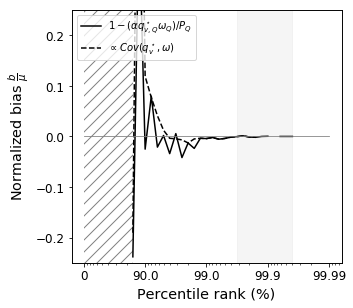

CPU times: user 1.14 s, sys: 23.4 ms, total: 1.17 s
Wall time: 1.18 s


In [494]:
%%time
print("> plot bias and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.25,.25))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 bias_sc,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 contribQOmega_bias_covQOmega,
                 col='k',ltype='--',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.legend([r'$1-(\alpha q_{v,Q}^\star \omega_Q) / P_Q$',r'$\propto Cov(q_v^\star,\omega)$'],
          loc = 'upper left')

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Normalized bias $\frac{b}{\mu}$')

plt.savefig(os.path.join(figdir,'bias_and_cov_omega_q_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

> plot bias for OGS09 scaling
- scaling scOGS09
- scaling scOGS09ad
- scaling scRH
- scaling scRHad


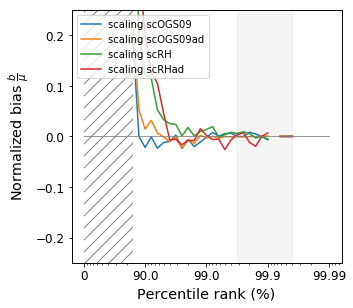

CPU times: user 1.06 s, sys: 28.1 ms, total: 1.09 s
Wall time: 1.18 s


In [495]:
%%time
print("> plot bias for OGS09 scaling")

scaling_names = 'scOGS09','scOGS09ad','scRH','scRHad'

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.25,.25))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

for sc_name in scaling_names:

    print("- scaling %s"%sc_name)

    setattr(thismodule,'bias',getattr(thismodule,'bias_%s'%(sc_name)))
    
    subplotRanksILog(ax,ranks_ref,
                     bias,
                     ltype='-',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)
    
ax.legend([r'scaling %s'%sc_name for sc_name in scaling_names],
          loc = 'upper left')

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Normalized bias $\frac{b}{\mu}$')

plt.savefig(os.path.join(figdir,'bias_%s_%s.pdf'%('_'.join(scaling_names),output_suffix)),
            bbox_inches='tight')

plt.show()

## Decompose the variance

### Decompose Variance into its contributions from qvstar and omega (scaling #3)

In [496]:
print()
print("-- decompose variance into qvstar and omega contributions")
print()


-- decompose variance into qvstar and omega contributions



In [497]:
%%time 
print("Compute the variance in pr")
scaling_names = 'sc','scOGS09','scOGS09ad','scRH','scRHad'

bootstrap = True
Ntimes = 100 if bootstrap else 1
fsub = 0.5 if bootstrap else 1

for sc_name in scaling_names:

    # compute variance from full sample
    pr_values = getattr(thismodule,'pr_%s'%sc_name)
    var_pr = varXAtAllYRanks(targetranks,pr_values,
                            pr,ranks_ref,rank_locations=rank_locations)
    setattr(thismodule,'var_pr_%s_prQ'%sc_name,var_pr)
    
    # bootstrapping
    all_var_pr = np.empty((Ntimes,var_pr.size))
    for i in range(Ntimes):
        all_var_pr[i,:] = varXAtAllYRanks(targetranks,pr_values,
                            pr,ranks_ref,rank_locations=rank_locations,random_fraction=fsub)
    if bootstrap:
        setattr(thismodule,'var_pr_%s_I25_prQ'%sc_name,all_var_pr[0])
        setattr(thismodule,'var_pr_%s_I75_prQ'%sc_name,all_var_pr[1])

Compute the variance in pr
CPU times: user 2.03 s, sys: 11.9 ms, total: 2.04 s
Wall time: 2.07 s


In [498]:
print("normalized variability")
for sc_name in scaling_names:
    norm_var_pr = getattr(thismodule,'var_pr_%s_prQ'%sc_name)/getattr(thismodule,'pr_%s_prQ'%sc_name)**2
    setattr(thismodule,'norm_var_pr_%s_prQ'%sc_name,norm_var_pr)
    if bootstrap:
        for int_bnd in 'I25','I75':
            norm_var_pr_Ibnd = getattr(thismodule,'var_pr_%s_%s_prQ'%(sc_name,int_bnd))/\
                getattr(thismodule,'pr_%s_prQ'%sc_name)**2
            setattr(thismodule,'norm_var_pr_%s_%s_prQ'%(sc_name,int_bnd),norm_var_pr_Ibnd)
            # for printing only:
            setattr(thismodule,'norm_var_pr_%s'%int_bnd,norm_var_pr_Ibnd)
    
    print("scaling %s : %1.5f"%(sc_name,np.nanmean(norm_var_pr[iQ_slice])),end='')
    if bootstrap:
        print("\t (%1.5f,%1.5f)"%(np.nanmean(norm_var_pr_I25[iQ_slice]),
                                  np.nanmean(norm_var_pr_I75[iQ_slice])))
    else:
        print()

normalized variability
scaling sc : 0.01232	 (0.00411,0.00083)
scaling scOGS09 : 0.00336	 (0.00106,0.00199)
scaling scOGS09ad : 0.00602	 (0.00284,0.00912)
scaling scRH : 0.00287	 (0.00601,0.00296)
scaling scRHad : 0.00346	 (0.01595,0.00601)


In [499]:
%%time
print("compute variability terms")
var_qvstar_s_prQ = varXAtAllYRanks(targetranks,qvstar_s,pr,ranks_ref,rank_locations=rank_locations)
var_omega_500_prQ = varXAtAllYRanks(targetranks,omega_500,pr,ranks_ref,rank_locations=rank_locations)
cov_qvstar_s_omega_500_prQ = covAtAllYRanks(targetranks,qvstar_s,omega_500,pr,ranks_ref,
                                            rank_locations=rank_locations)
cov_qvstar_s_2_omega_500_2_prQ = covAtAllYRanks(targetranks,qvstar_s**2,omega_500**2,pr,ranks_ref,
                                                rank_locations=rank_locations)

compute variability terms
CPU times: user 18.8 ms, sys: 1.06 ms, total: 19.9 ms
Wall time: 19.1 ms


In [500]:
print("normalized contributions, expanded terms")

# a_v = (eps/gg)**2
# contrib_covX2Y2 = a_v*cov_qvstar_s_2_omega_500_2_prQ/(pr_sc_prQ**2)
# contrib_varX = a_v*(omega_500_prQ**2)*var_qvstar_s_prQ/(pr_sc_prQ**2)
# contrib_varY = a_v*(qvstar_s_prQ**2)*var_omega_500_prQ/(pr_sc_prQ**2)
# contrib_varXvarY = a_v*var_qvstar_s_prQ*var_omega_500_prQ/(pr_sc_prQ**2)
# contrib_cov2XY = -a_v*(cov_qvstar_s_omega_500_prQ**2)/(pr_sc_prQ**2)
# contrib_covXY = -a_v*2*qvstar_s_prQ*omega_500_prQ*cov_qvstar_s_omega_500_prQ/(pr_sc_prQ**2)
contribQOmega_var_covQ2Omega2 = cov_qvstar_s_2_omega_500_2_prQ/((omega_500_prQ*qvstar_s_prQ)**2)
contribQOmega_var_varQ = var_qvstar_s_prQ/(qvstar_s_prQ**2)
contribQOmega_var_varOmega = var_omega_500_prQ/(omega_500_prQ**2)
contribQOmega_var_varQvarOmega = var_qvstar_s_prQ*var_omega_500_prQ/((omega_500_prQ*qvstar_s_prQ)**2)
contribQOmega_var_cov2QOmega = -(cov_qvstar_s_omega_500_prQ**2)/((omega_500_prQ*qvstar_s_prQ)**2)
contribQOmega_var_covQOmega = -2*cov_qvstar_s_omega_500_prQ/(omega_500_prQ*qvstar_s_prQ)
contribQOmega_var_sum = contribQOmega_var_covQ2Omega2 + contribQOmega_var_varQ + contribQOmega_var_varOmega + \
    contribQOmega_var_varQvarOmega + contribQOmega_var_cov2QOmega + contribQOmega_var_covQOmega

print(np.nanmean(contribQOmega_var_covQ2Omega2[iQ_slice]),np.nanmean(contribQOmega_var_varQ[iQ_slice]),
      np.nanmean(contribQOmega_var_varOmega[iQ_slice]),np.nanmean(contribQOmega_var_varQvarOmega[iQ_slice]),
      np.nanmean(contribQOmega_var_cov2QOmega[iQ_slice]),np.nanmean(contribQOmega_var_covQOmega[iQ_slice]),
      np.nanmean(contribQOmega_var_sum[iQ_slice]))

normalized contributions, expanded terms
-0.00128183163458 0.000499443244226 0.0124527068951 3.07204434724e-06 -1.19939229838e-06 0.000664586436792 0.0123367775936


> plot variance and corresponding contributions


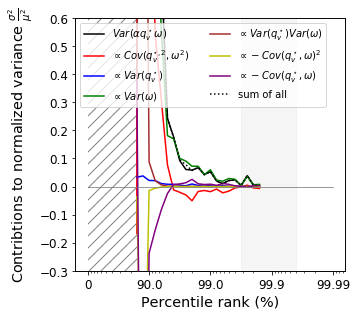

CPU times: user 1.73 s, sys: 38.8 ms, total: 1.77 s
Wall time: 1.79 s


In [501]:
%%time
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_sc_prQ,
                 col='k',ltype='-',transformX=False)
subplotRanksILog(ax,ranks_ref,
                 [contribQOmega_var_covQ2Omega2,contribQOmega_var_varQ,contribQOmega_var_varOmega,
                  contribQOmega_var_varQvarOmega,contribQOmega_var_cov2QOmega,contribQOmega_var_covQOmega,
                  contribQOmega_var_sum],
                 col=['r','b','g','brown','y','purple','k'],ltype=['-','-','-','-','-','-',':'],transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

leg = ax.legend([r'$Var(\alpha q_v^\star \omega)$',
                 r'$\propto Cov(q_v^{\star,2},\omega^2)$',
                 r'$\propto Var(q_v^\star)$',
                 r'$\propto Var(\omega)$',
                 r'$\propto Var(q_v^\star)Var(\omega)$',
                 r'$\propto -Cov(q_v^\star,\omega)^2$',
                 r'$\propto -Cov(q_v^\star,\omega)$',
                 r'sum of all'],
                 loc='upper left',
                 framealpha=0.8,
                 ncol=2)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contribtions to normalized variance $\frac{\sigma^2}{\mu^2}$')

plt.savefig(os.path.join(figdir,'var_and_contributions_omega_q_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

> plot variance for vertical scalings
- add scaling scOGS09
- add scaling scOGS09ad
- add scaling scRH
- add scaling scRHad


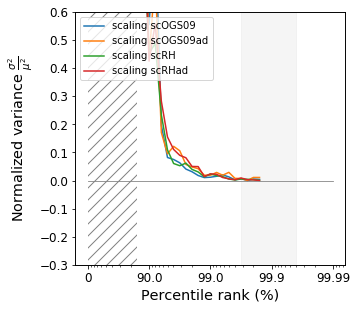

CPU times: user 1.05 s, sys: 25.6 ms, total: 1.08 s
Wall time: 1.09 s


In [502]:
%%time
print("> plot variance for vertical scalings")

scaling_names = 'scOGS09','scOGS09ad','scRH','scRHad'


fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)
    
for sc_name in scaling_names:

    print("- add scaling %s"%sc_name)
    setattr(thismodule,'norm_var',getattr(thismodule,'norm_var_pr_%s_prQ'%(sc_name)))

    subplotRanksILog(ax,ranks_ref,
                     norm_var,
                     ltype='-',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

leg = ax.legend([r'scaling %s'%sc_name for sc_name in scaling_names],
                 loc='upper left',
                 framealpha=0.8)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Normalized variance $\frac{\sigma^2}{\mu^2}$')

plt.savefig(os.path.join(figdir,'var_%s_%s.pdf'%('_'.join(scaling_names),output_suffix)),
            bbox_inches='tight')

plt.show()

### Decompose variance into its contributions from T and omega (ignore variability in pressure)

In [503]:
print()
print("-- decompose variance into T and omega contributions")
print()


-- decompose variance into T and omega contributions



In [504]:
print("Q-mean terms")
ts_prQ = meanXAtAllYRanks(targetranks,ts,pr,ranks_ref,rank_locations=rank_locations)

Q-mean terms


In [505]:
%%time
print("compute variability terms")
var_ts_prQ = varXAtAllYRanks(targetranks,ts,pr,ranks_ref,rank_locations=rank_locations)
cov_ts_omega_500_prQ = covAtAllYRanks(targetranks,ts,omega_500,pr,ranks_ref,rank_locations=rank_locations)
cov_ts_omega_500_2_prQ = covAtAllYRanks(targetranks,ts,omega_500**2,pr,ranks_ref,rank_locations=rank_locations)

compute variability terms
CPU times: user 15 ms, sys: 1.74 ms, total: 16.8 ms
Wall time: 15.3 ms


In [506]:
print("normalized contributions, expanded terms")

contribTOmega_var_covTOmega2 = 2*L_v/R_v*cov_ts_omega_500_2_prQ/(ts_prQ*omega_500_prQ)**2
contribTOmega_var_covTOmega = -2*L_v/R_v*cov_ts_omega_500_prQ/((ts_prQ**2)*omega_500_prQ)
contribTOmega_var_varT = ((L_v/R_v)**2)*var_ts_prQ/(ts_prQ**4)
contribTOmega_var_varOmega = var_omega_500_prQ/(omega_500_prQ**2)
contribTOmega_var_sum = contribTOmega_var_covTOmega2+contribTOmega_var_covTOmega+contribTOmega_var_varT+\
    contribTOmega_var_varOmega
all_contribTOmega_var = [contribTOmega_var_covTOmega2,contribTOmega_var_covTOmega,contribTOmega_var_varT,
                    contribTOmega_var_varOmega,contribTOmega_var_sum]
for contrib in all_contribTOmega_var:
    print(np.nanmean(contrib[iQ_slice]),end=' ')
print()

normalized contributions, expanded terms
-0.0260326772061 0.0131290022351 0.0133319871082 0.0124527068951 0.0128810190324 


> plot variance and corresponding contributions


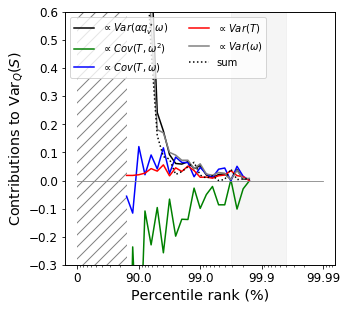

CPU times: user 1.48 s, sys: 30.8 ms, total: 1.51 s
Wall time: 1.55 s


In [507]:
%%time 
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_ylim((-0.3,0.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

# subplotRanksILog(ax,ranks,np.zeros(ranks.shape),ltype=':',col='k')
subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_sc_prQ,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 all_contribTOmega_var,
                 col=['green','blue','red','grey','k'],ltype=['-','-','-','-',':'],transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contributions to Var$_Q(S)$')
# ax.set_title(r'$S(\omega,T)=\varepsilon\omega_{500}q_v^\star(T)$')

ax.legend([r'$\propto Var(\alpha q_v^\star \omega)$',r'$\propto Cov(T,\omega^2)$',r'$\propto Cov(T,\omega)$',
           r'$\propto Var(T)$',
           r'$\propto Var(\omega)$','sum'],ncol=2,framealpha=0.8,loc='upper left')

plt.savefig(os.path.join(figdir,'var_and_contributions_omega_T_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

## Predictor variables statistics

### Joint statistics of $\omega$ and $q_v^\star$

In [508]:
print()
print("-- compute joint statistics of omega and qvstar")
print()


-- compute joint statistics of omega and qvstar



In [509]:
print("2D density")
ranks_omega_500, percentiles_omega_500, bins_omega_500, \
ranks_qvstar_s, percentiles_qvstar_s, bins_qvstar_s, density2D_omega_500_qvstar_s = \
    compute2dStatsILOnRefRanks(-omega_500,qvstar_s,ranks_ref,n_pts_per_bin=1)
    
print("normalized 2D density")
N1 = N_omega_500 = sampleSizeAtAllRanks(ranks_omega_500,-omega_500,ranks_ref,bins=bins_omega_500)
N2 = N_qvstar_s = sampleSizeAtAllRanks(ranks_qvstar_s,qvstar_s,ranks_ref,bins=bins_qvstar_s)
norm_factor = normalize2dDensity(N1,N2,n_pts)

norm_density2D_omega_500_qvstar_s = density2D_omega_500_qvstar_s/norm_factor

2D density
normalized 2D density


> plot 2D PDF of omega_500 and qvstar_s


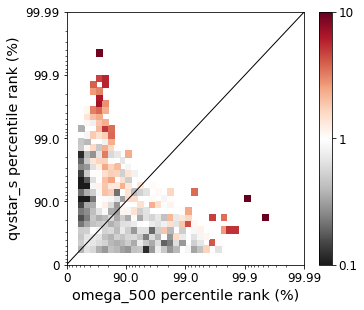

In [510]:
print("> plot 2D PDF of omega_500 and qvstar_s")
fig, ax = plt.subplots(figsize=(5.5,4.5))

subplot2DRanksILog(ax,ranks_ref,ranks_ref,norm_density2D_omega_500_qvstar_s,
                   cmap=plt.cm.RdGy_r,transformX=True,transformY=True,Z_mode='log')

add1to1Line(ax)

ax.set_xlabel('omega_500 percentile rank (%)')
ax.set_ylabel('qvstar_s percentile rank (%)')

plt.savefig(os.path.join(figdir,'norm_pdf2D_%s_and_%s_%s.pdf'%('omega_500','qvstar_s',output_suffix)),
                bbox_inches='tight')
plt.show()

In [511]:
# print("compute sample size in 2D bins of omega_500 and qvstar_s")

# sampleSize_omega_500_qvstar_s = sampleSizeAtAllY1Y2Ranks(ranks_ref,ranks_ref,omega_500,qvstar_s,
#     Y1ranks=ranks_ref,Y1bins=bins_omega_500,Y1rank_locations=None,
#     Y2ranks=ranks_ref,Y2bins=bins_qvstar_s,Y2rank_locations=None)

# fig, ax = plt.subplots(figsize=(5.5,4.5))

# subplot2DRanksILog(ax,ranks_ref,ranks_ref,sampleSize_omega_500_qvstar_s,
#                    cmap='viridis',transformX=True,transformY=True)

# add1to1Line(ax)

# ax.set_xlabel('omega_500 percentile rank (%)')
# ax.set_ylabel('qvstar_s percentile rank (%)')

### Conditional values of $P$ on joint statistics of $\omega$ and $q_v^\star$

In [512]:
print()
print("-- compute mean values conditioned on omega_500 and qvstar_s")
print()
varnames = 'pr','pr_sc','pr_scOGS09'


-- compute mean values conditioned on omega_500 and qvstar_s



In [513]:
print("ranks_locations for omega_500 and qvstar_s")
print("TO DO TO SAVE COMPUTING TIME")

ranks_locations for omega_500 and qvstar_s
TO DO TO SAVE COMPUTING TIME


In [514]:
print("prepare axes and bins for predictor variables")
ranks_omega_500, percentiles_omega_500, bins_omega_500 = computePercentilesAndBinsFromRanks(-omega_500.flatten(),ranks_ref,crop=False)
percentiles_omega_500 = adjustRanks(percentiles_omega_500,ranks_omega_500,ranks_ref)
bins_omega_500 = adjustBinsOnRanks(bins_omega_500,ranks_omega_500,ranks_ref)
ranks_omega_500 = ranks_ref
ranks_qvstar_s, percentiles_qvstar_s, bins_qvstar_s = computePercentilesAndBinsFromRanks(qvstar_s.flatten(),ranks_ref,crop=False)
percentiles_qvstar_s = adjustRanks(percentiles_qvstar_s,ranks_qvstar_s,ranks_ref)
bins_qvstar_s = adjustBinsOnRanks(bins_qvstar_s,ranks_qvstar_s,ranks_ref)
ranks_qvstar_s = ranks_ref

prepare axes and bins for predictor variables


In [515]:
print("compute ranks, percentiles and bins for predicted variables")

for varname in varnames:
    
    print("- %s"%varname)

    var = getattr(thismodule,varname)
    
    ranks_var, percentiles_var, bins_var = computePercentilesAndBinsFromRanks(var.flatten(),ranks_ref,crop=False)
    setattr(thismodule,"ranks_%s"%varname,ranks_var)
    setattr(thismodule,"percentiles_%s"%varname,percentiles_var)
    setattr(thismodule,"bins_%s"%varname,bins_var)

compute ranks, percentiles and bins for predicted variables
- pr
- pr_sc
- pr_scOGS09


In [516]:
print("compute conditional values")

for varname in varnames:

    print("- %s"%varname)
    
    val_cond = meanXAtAllY1Y2Ranks(ranks_ref,ranks_ref,getattr(thismodule,varname),-omega_500,qvstar_s,\
                                Y1ranks=ranks_ref,Y1bins=bins_omega_500,\
                                Y2ranks=ranks_ref,Y2bins=bins_qvstar_s)
    setattr(thismodule,"%s_omega_500Q_qvstar_sQ"%varname,val_cond)


compute conditional values
- pr
- pr_sc
- pr_scOGS09


> plot precipitation conditioned on omega_500 and qvstar_s
- pr
0
- for pr_omega_500Q_qvstar_sQ


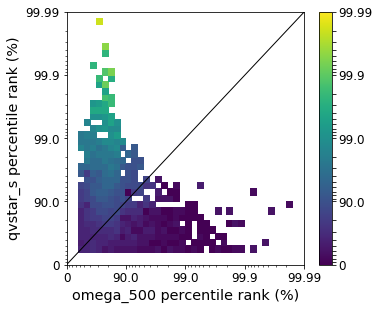

- pr_sc
0
- for pr_sc_omega_500Q_qvstar_sQ


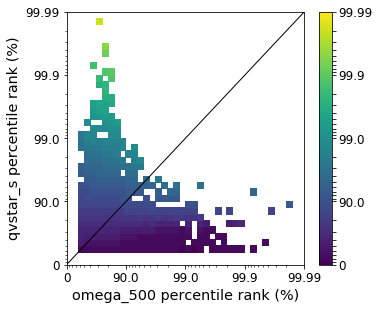

- pr_scOGS09
0
- for pr_scOGS09_omega_500Q_qvstar_sQ


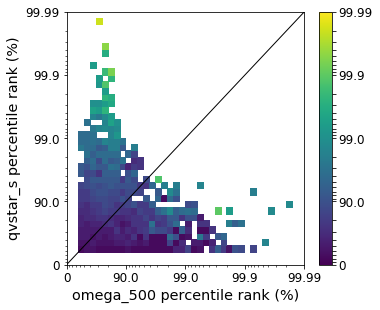

In [517]:
print("> plot precipitation conditioned on omega_500 and qvstar_s")

for varname in varnames:

    print("- %s"%varname)
    
    var_cond = getattr(thismodule,"%s_omega_500Q_qvstar_sQ"%varname)
    ranks_var = getattr(thismodule,"ranks_%s"%varname)
    percentiles_var = getattr(thismodule,"percentiles_%s"%varname)
    bins_var = getattr(thismodule,"bins_%s"%varname)
    
    ranks_cond = getRanksOfValues(var_cond,ranks_var,percentiles_var,bins_var)
    setattr(thismodule,"ranks_%s_omega_500Q_qvstar_sQ"%varname,ranks_cond)
    
    print("- for %s_omega_500Q_qvstar_sQ"%varname)

    fig, ax = plt.subplots(figsize=(5.5,4.5))

    subplot2DRanksILog(ax,ranks_ref,ranks_ref,ranks_cond,cmap='viridis',
        transformX=True,transformY=True,range_type='full_positive',Z_mode='invlog',ranksZ=ranks_ref)

    add1to1Line(ax)

    ax.set_xlabel('omega_500 percentile rank (%)')
    ax.set_ylabel('qvstar_s percentile rank (%)')

    plt.savefig(os.path.join(figdir,'%s_conditioned_on_omega_500_and_qvstar_s_%s.pdf'%(varname,output_suffix)),
                    bbox_inches='tight')
    plt.show()

# Save all variables in dataframe

In [399]:
print("-- Save results")
import pandas as pd
import re
import pickle

-- Save results


In [433]:
print("> save variables in dataframe")

vars_out_Q = ['ranks_ref','percentiles']
for prefix in ('percentiles','ranks'):
    for prvarname in ('pr','omega_500','qvstar_s','pr_sc','pr_scOGS09','pr_scOGS09ad','pr_scRH','pr_scRHad'):
        varname = '%s_%s'%(prefix,prvarname)
        if varname in locals().keys():
            vars_out_Q.append(varname)
        else:
            print(varname,'does not exist')
        
    
vars_out_Q.extend([v for v in locals().keys() if v.endswith('prQ') or v.endswith('vQ')])
vars_out_Q.extend([v for v in locals().keys() if v.startswith('contrib')])
vars_out_Q.extend([v for v in locals().keys() if v.startswith('norm_var_pr')])
vars_out_Q.extend([v for v in locals().keys() if v.startswith('bias_')])
vars_out_Q.extend([v for v in locals().keys() if v.startswith('N_')])


> save variables in dataframe


In [434]:
vars_out_Q = list(set(vars_out_Q))
vars_out_Q.sort()
for v in vars_out_Q:
    obj = getattr(thismodule,v)
    if obj.__class__ is np.ndarray:
        print('-',v,obj.__class__,sys.getsizeof(obj),obj.shape)
    else:
        print('-',v,obj.__class__,sys.getsizeof(obj))

- N_omega_500 <class 'numpy.ndarray'> 424 (41,)
- N_pr <class 'numpy.ndarray'> 424 (41,)
- N_prQ <class 'numpy.ndarray'> 424 (41,)
- N_pr_sc <class 'numpy.ndarray'> 424 (41,)
- N_pr_scOGS09 <class 'numpy.ndarray'> 424 (41,)
- N_pr_scOGS09ad <class 'numpy.ndarray'> 424 (41,)
- N_pr_scRH <class 'numpy.ndarray'> 424 (41,)
- N_pr_scRHad <class 'numpy.ndarray'> 424 (41,)
- N_qvstar_s <class 'numpy.ndarray'> 424 (41,)
- bias_sc <class 'numpy.ndarray'> 424 (41,)
- bias_scOGS09 <class 'numpy.ndarray'> 424 (41,)
- bias_scOGS09ad <class 'numpy.ndarray'> 424 (41,)
- bias_scRH <class 'numpy.ndarray'> 424 (41,)
- bias_scRHad <class 'numpy.ndarray'> 424 (41,)
- contrib <class 'numpy.ndarray'> 424 (41,)
- contribQOmega_bias_covQOmega <class 'numpy.ndarray'> 424 (41,)
- contribQOmega_var_cov2QOmega <class 'numpy.ndarray'> 424 (41,)
- contribQOmega_var_covQ2Omega2 <class 'numpy.ndarray'> 424 (41,)
- contribQOmega_var_covQOmega <class 'numpy.ndarray'> 424 (41,)
- contribQOmega_var_sum <class 'numpy.ndar

In [318]:
print("create result dataframe")
results_df = pd.DataFrame({v:getattr(thismodule,v) for v in vars_out_Q})

create result dataframe


In [397]:
result_df_file = 'results_dataframe_%s.csv'%output_suffix
print("> save results to %s"%result_df_file)
results_df.to_csv(os.path.join(resultdir,result_df_file))
print("total size of dataframe =",sys.getsizeof(results_df),"B")
print()

> save results to results_dataframe_Q8-Q41_185005010100-185005020000.csv
total size of dataframe = 25360 B



In [438]:
print("> save variables with pickle.dump")

remaining_variables = set(locals().keys()).difference(set(vars_out_Q))

# efficiencies
var_to_pickle = ['n_pts','eps','eps_OGS09','eps_OGS09ad']
var_to_pickle.extend(['fracarea_boost','fracarea_boost_ad','entrainment','entrainment_ad'])
# bins
var_to_pickle.extend([v for v in remaining_variables if v.startswith('bins_')])
# densities
var_to_pickle.extend([v for v in remaining_variables if v.startswith('density2D_')])
var_to_pickle.extend([v for v in remaining_variables if v.startswith('norm_density2D_')])
var_to_pickle.extend([v for v in remaining_variables if v.startswith('pdf1D_')])
var_to_pickle.extend([v for v in remaining_variables if v.startswith('percentiles_pr_')])

for varname in 'pr_sc','pr_scOGS09','pr_scOGS09ad','pr_scRH','pr_scRHad':
    var_to_pickle.extend([v for v in remaining_variables if v.startswith("%s_"%varname)])
    
var_to_pickle.append('pr_omega_500Q_qvstar_sQ')
var_to_pickle.extend([v for v in remaining_variables if v.startswith('ranks_pr_')])

var_to_pickle = list(set(var_to_pickle))
var_to_pickle.sort()

> save variables with pickle.dump


In [439]:
all_vars_to_save = list(set(vars_out_Q+var_to_pickle))
all_vars_to_save.sort()

print(len(all_vars_to_save),"variables")

size_pickle = 0
dict_pickle = {}
for v in all_vars_to_save:
    obj = getattr(thismodule,v)
    size_pickle += sys.getsizeof(obj)
    if obj.__class__ is np.ndarray:
        print('-',v,obj.__class__,sys.getsizeof(obj),obj.shape)
    else:
        print('-',v,obj.__class__,sys.getsizeof(obj))
    # save variables
    dict_pickle[v] = obj

315 variables
- N_omega_500 <class 'numpy.ndarray'> 424 (41,)
- N_pr <class 'numpy.ndarray'> 424 (41,)
- N_prQ <class 'numpy.ndarray'> 424 (41,)
- N_pr_sc <class 'numpy.ndarray'> 424 (41,)
- N_pr_scOGS09 <class 'numpy.ndarray'> 424 (41,)
- N_pr_scOGS09ad <class 'numpy.ndarray'> 424 (41,)
- N_pr_scRH <class 'numpy.ndarray'> 424 (41,)
- N_pr_scRHad <class 'numpy.ndarray'> 424 (41,)
- N_qvstar_s <class 'numpy.ndarray'> 424 (41,)
- bias_sc <class 'numpy.ndarray'> 424 (41,)
- bias_scOGS09 <class 'numpy.ndarray'> 424 (41,)
- bias_scOGS09ad <class 'numpy.ndarray'> 424 (41,)
- bias_scRH <class 'numpy.ndarray'> 424 (41,)
- bias_scRHad <class 'numpy.ndarray'> 424 (41,)
- bins_%s <class 'numpy.ndarray'> 432 (42,)
- bins_omega_500 <class 'numpy.ndarray'> 432 (42,)
- bins_pr <class 'numpy.ndarray'> 432 (42,)
- bins_pr_sc <class 'numpy.ndarray'> 432 (42,)
- bins_pr_scOGS09 <class 'numpy.ndarray'> 432 (42,)
- bins_pr_scOGS09_pr_Q25Q35 <class 'numpy.ndarray'> 256 (20,)
- bins_pr_scOGS09_pr_Q26Q34 <cla

In [412]:
result_dict_file = 'results_dictionary_%s.pickle'%output_suffix
print("> save to file %s"%result_dict_file)
pickle.dump(dict_pickle,open(os.path.join(resultdir,result_dict_file),"wb"))
print("total size =",size_pickle,"B")

> save to file results_dictionary_Q8-Q41_185005010100-185005020000.pickle
total size = 1163828 B


In [413]:
print()
print("-------")
print()
if tracktime:
    timingfile = 'timing.csv'
    fulltimingfile = os.path.join(resultdir,timingfile)
    t1 = time.time()
    time_elapsed_s = t1-t0
    timing_df = saveTiming(fulltimingfile,output_suffix,pr.size,time_elapsed_s,reset_value=True)
print()


-------

Script successfully terminated in 8:44:02.708156.
> Save timing and size info to /Users/bfildier/Code/researchProjects/dataAnalysis/extremeRainPredictabilityAcrossScales/results/omega500tsps/FSPCAMm_AMIP/piControl/r1i1p1/tropics/1d/1dx/timing.csv.



In [27]:
## Keep track of time
if tracktime:
    t_loops.append(time.time())
    print()
    print("----------------------------------------------------------------")
    print("!")
    for i in range(len(t_loops)-1):
        print("! time spent in each loop:",t_loops[i+1]-t_loops[i])
    print("!")
    print("! time spent in all loops combined:",t_loops[-1]-t_loops[0])
    print("!")
    print("! total time spent for script execution:",t_loops[-1]-t0)
    print("!")
    print("-------------------------------------------------------------")
        


----------------------------------------------------------------
!
! time spent in each loop: 22.322679042816162
! time spent in each loop: 25.822925806045532
!
! time spent in all loops combined: 48.145604848861694
!
! total time spent for script execution: 476.6047739982605
!
-------------------------------------------------------------


In [440]:
# leftwith = []
# for k in locals().keys():
#     if not k.startswith('_') and k not in vars_out_Q and k not in var_to_pickle:
#         leftwith.append(k)
# leftwith.sort()
# print(len(leftwith))
# for k in leftwith:
#     print(k)